### Reconhecimento de emoções.

O principal objetivo desse notebook é fazer um treinando de uma rede neural que consiga detectar emoções em tempo real usando imagem de uma camera (Webcam para começar).

Para isso usaremos o dataset FER2013 (Facial Expression Recognition), disponível para download [aqui](https://www.kaggle.com/msambare/fer2013).

Iremos explicar todo o passo a passo, desde o processamento inicial das imagens, até o final do treinamento das redes neurais onde salvaremos alguns modelos para criar um API que ficará disponível para teste do público.

Vamos importar as bibliotecas a medida que formos precisando delas.

### Processamento das imagens e criação de um arquivo CSV.

O Dataset FER2013 está dividido em pastas, uma de treinamento e outra de teste, cada uma dessas pastas tem sete categorias de expressões, são elas:

 - 0: Zangado
 - 1: Nojo 
 - 2: Medo 
 - 3: Feliz
 - 4: Natural
 - 5: Triste
 - 6: Surpresa

A melhor maneira de trabalhar com essas imagens em uma rede neural é utilizando a função de pré-processamento "ImageDataGenerator" do Keras.

Vamos fazer isso para separar os dados de treino e de teste.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# diretorios de treino e teste

dir_treino = "imagens/train"
dir_teste = "imagens/test"

In [3]:
# criando os dataset de treino e teste

gerar_datatreino = ImageDataGenerator()
gerar_datateste = ImageDataGenerator()

Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                      target_size=(48,48),
                                                      batch_size= 70, color_mode = 'grayscale',
                                                      class_mode='categorical')

Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=(48,48),
                                                      batch_size= 64, color_mode = 'grayscale',
                                                      class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# dicionário com os significados de cada classe

dict_emocoes = {
    0: "Zangado", 
    1: "Nojo", 
    2: "Medo", 
    3: "Feliz",
    4: "Natural", 
    5: "Triste", 
    6: "Surpresa"
}

Temos nossos dados separados, porém eles estão em formatos de um dataset do keras, cada elemento do Xtreino é um batch com 70 imagens do dataset de treino, então vamos usar algumas funções do tensorflow para conseguir visualizar essas imagens nesse dataset.

[Documentação - tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [5]:
type(Xtreino)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [6]:
# pegando o primeiro batch para visualizar as suas imagens

datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[1])
listaTreino = list(datasetTreino.as_numpy_iterator())

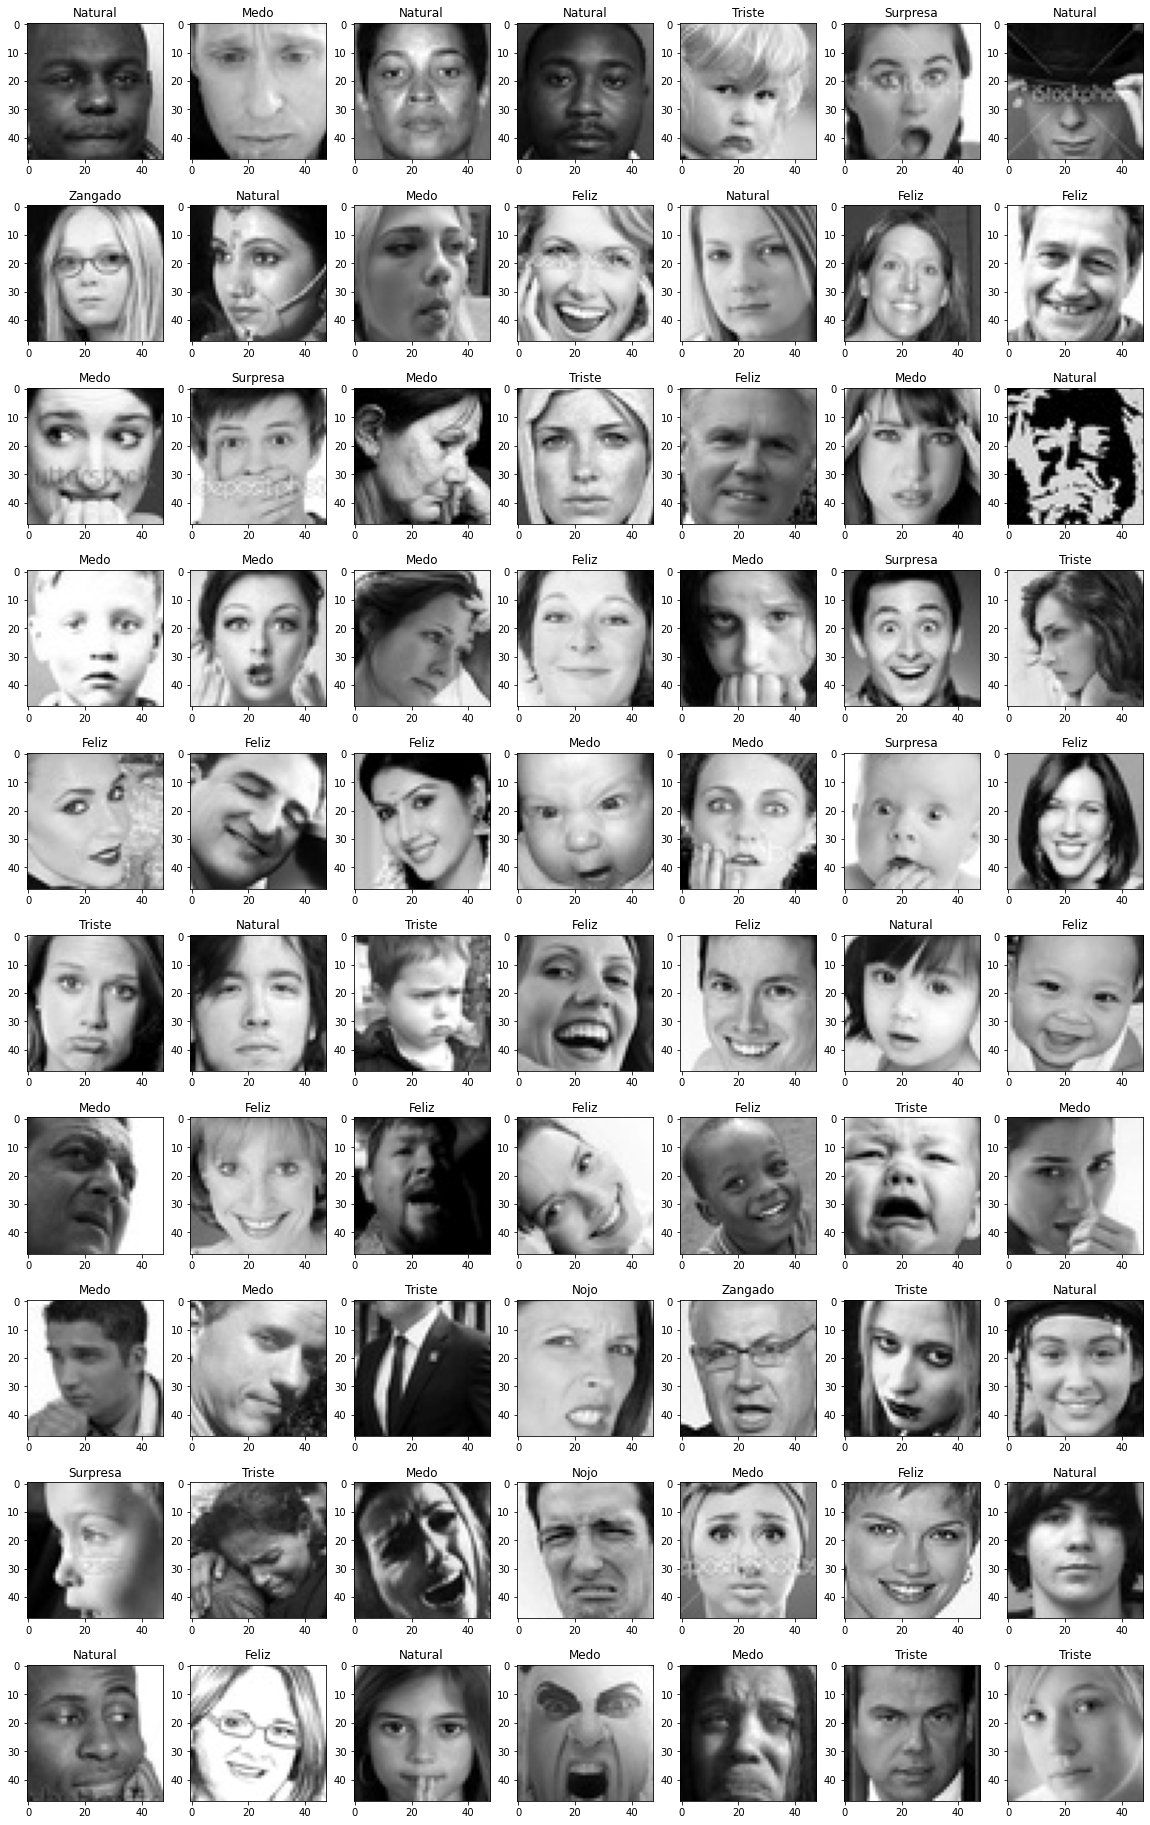

In [7]:
# visualizando algumas imagens

plt.figure(figsize=(20,33))
for n in range(len(listaTreino)):
    plt.subplot(10,7,n+1)
    plt.imshow(listaTreino[n][0],cmap='gray')
    plt.title(dict_emocoes[np.argmax(listaTreino[n][1])])
plt.show()

### Criando arquivo .CSV

Pode ser interessante criar um arquivo .csv dessas imagens, assim podemos ter um recurso a mais para trabalhar, também podemos com esse aquivo agrupar as imagens para fazer uma contagem de quantas fotos de cada categoria temos.

O código abaixo cria um arquivo csv de todas as imagens armazenadas no dataset Xtreino.

In [8]:
listaTreino1 = []
for item in listaTreino:
    item1 = dict_emocoes[np.argmax(item[1])]
    listaTreino1.append([item[0],item1])

array = np.array(listaTreino1, dtype = object)
df_emotions = pd.DataFrame(array, columns = ['pixels', 'categoria'])

for n in range(1,len(Xtreino)):
    datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
    listaTreino = list(datasetTreino.as_numpy_iterator())
    listaTreino2 = []
    for item in listaTreino:
        item1 = dict_emocoes[np.argmax(item[1])]
        listaTreino2.append([item[0],item1])
    array1 = np.array(listaTreino2, dtype = object)
    df_emotions1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
    df_emotions = pd.concat([df_emotions, df_emotions1])

In [9]:
# conferindo o tamanho

df_emotions.shape

(28709, 2)

In [10]:
df_emotions.head()

,pixels,categoria
0,"[[[55.0], [55.0], [55.0], [58.0], [63.0], [67....",Natural
1,"[[[64.0], [53.0], [111.0], [158.0], [153.0], [...",Medo
2,"[[[128.0], [111.0], [65.0], [50.0], [51.0], [5...",Natural
3,"[[[60.0], [60.0], [60.0], [57.0], [61.0], [61....",Natural
4,"[[[163.0], [167.0], [153.0], [166.0], [171.0],...",Triste


In [11]:
# contando quantas imagens temos em cada categoria

df_count = df_emotions.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Emoção', 
                                                                    'categoria': 'Quantidade'
                                                                    })

df_count

,Emoção,Quantidade
0,Feliz,7220
1,Natural,4963
2,Triste,4827
3,Medo,4108
4,Zangado,3985
5,Surpresa,3168
6,Nojo,438


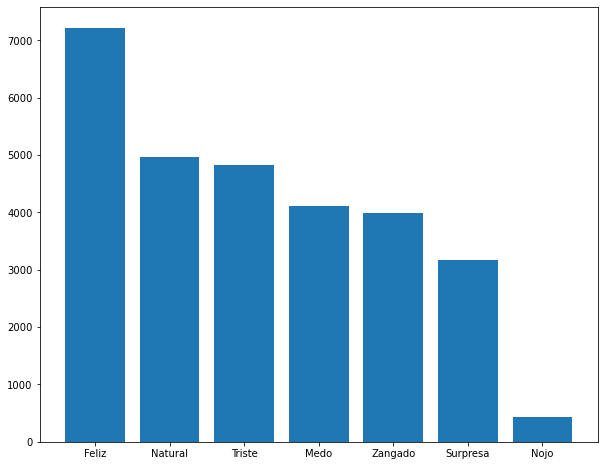

In [12]:
# plotando um gráfico

plt.figure(figsize=(10,8))
plt.bar(df_count['Emoção'],df_count['Quantidade'])
plt.show()

In [13]:
# criando um arquivo em csv com as imagens já em formato de mátrizes

df_emotions.to_csv('datasets/emotions.csv')

Pronto, concluimos a criação do nosso arquivo csv com as imagens já em forma de matriz e com cada categoria dela.

### Criando uma classe para todo o processo.

Todo esse processo feito acima pode ser util em outras situações futuras, vamos criar então uma classe, onde juntamos todo esse processamento em um único lugar, assim não precisaremos ficar repetindo sempre, quando precisar trabalhar com outro conjunto de imagens.

In [14]:
class processamento_imagens_categorias():
    '''
    Classe para processar imagens organizadas em pastas separas por categórias. 
    '''

    def __init__(self, dir_treino, dir_teste, shape, cores = 3, dici = None):
        '''
        dir_treino: diretório da pasta de treino
        dir_teste: diretório da paste de teste
        shape: dimensão das imagens dos diretório, exemplo (48,48)
        cores: cor da imagem, 1 para preto e branco, 3 para RGB e 4 para RBA.
        '''
    
        self.dir_treino = dir_treino
        self.dir_teste = dir_teste
        self.shape = shape
        self.cores = cores
        self.dici = dici
        
    def gerar_datasets(self, batch = 32):
        '''
        Gera dois datasets do Keras divididos em treino e teste agrupados pelo tamanho do Batchsize escolhido
        
        batch: Batchsize escolhido para o agrupamento nos dados de treino e teste.
        '''
        self.batch = batch
        gerar_datatreino = ImageDataGenerator()
        gerar_datateste = ImageDataGenerator()
        
        if self.cores == 1:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'grayscale',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'grayscale',
                                                      class_mode='categorical')
        elif self.cores == 3:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'rgb',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'rgb',
                                                      class_mode='categorical')
        elif self.cores == 4:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'rgba',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'rgba',
                                                      class_mode='categorical')
        else:
            print("O parametro 'Cores' escolhido na criação do objeto precisa ser 1, 3 ou 4")
                  
    def plotar_batch(self, n):
        '''
        Plota imagens do n-esimo batch escolhido 
        '''
        try:
            if self.dici == None:
                datasetTreino = tf.data.Dataset.from_tensor_slices(self.Xtreino[n])
                listaTreino = list(datasetTreino.as_numpy_iterator())
                plt.figure(figsize=(20, int(self.batch/2)))
                for n1 in range(len(listaTreino)):
                    plt.subplot(int(self.batch/7)+1,7,n1+1)
                    plt.imshow(listaTreino[n1][0],cmap='gray')
                    plt.title(np.argmax(listaTreino[n1][1]))
                plt.show()
            else:
                datasetTreino = tf.data.Dataset.from_tensor_slices(self.Xtreino[n])
                listaTreino = list(datasetTreino.as_numpy_iterator())
                plt.figure(figsize=(20, int(self.batch/2)))
                for n1 in range(len(listaTreino)):
                    plt.subplot(int(self.batch/7)+1,7,n1+1)
                    plt.imshow(listaTreino[n1][0],cmap='gray')
                    plt.title(self.dici[np.argmax(listaTreino[n1][1])])
                plt.show()
        except:         
            print('Você precisa escolher um n entre 0 e ', len(self.Xtreino)-1)
    def criar_csv_e_dataframe_pandas(self, nome_arquivo):
        '''
        Cria um dataset pandas e um arquivo nome_arquivo.csv com as imagens em formato de matriz e com as categorias especificas de cada.
        Além disso cria um dataset com a contagem de todos os elementos agrupados pelas categorias.
        
        dici: Dicionário onde as chaves são as categorias e os valores, os nomes das categorias.
        
        Exemplo, caso o dataset seja um de imagens apenas de gatos e cachorro, crie um dicionário da forma: 
        
        dicionario = {
                0: 'gato'
                1: 'cachorro'
            }
        
        E adicione esse dicionario como parâmetro na variavél dici
        
        Caso o dicionário não seja colocado, a coluna de categorias vira com os valores categóricos de cada uma delas
        '''
        
        self.nome = nome_arquivo
        listaTreino1 = []
        if self.dici == None:
            for item in listaTreino:
                item1 = np.argmax(item[1])
                listaTreino1.append([item[0],item1])

            array = np.array(listaTreino1, dtype = object)
            df_final = pd.DataFrame(array, columns = ['pixels', 'categoria'])

            for n in range(1,len(Xtreino)):
                datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
                self.listaTreino = list(datasetTreino.as_numpy_iterator())
                listaTreino2 = []
                for item in self.listaTreino:
                    item1 = np.argmax(item[1])
                    listaTreino2.append([item[0],item1])
                array1 = np.array(listaTreino2, dtype = object)
                df_final1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
                df_final = pd.concat([df_final, df_final1])
            self.df_final = df_final
            self.df_contagem = df_count = self.df_final.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Categorias', 
                                                                    'categoria': 'Quantidade'
                                                                    })
            self.df_final.to_csv(self.nome+'.csv')
            print(f"Arquivo {self.nome}.csv criado, utilize os atributos .df_final e .df_contagem para acessar os datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria")
        
        else: 
            for item in listaTreino:
                item1 = self.dici[np.argmax(item[1])]
                listaTreino1.append([item[0],item1])

            array = np.array(listaTreino1, dtype = object)
            df_final = pd.DataFrame(array, columns = ['pixels', 'categoria'])

            for n in range(1,len(Xtreino)):
                datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
                self.listaTreino = list(datasetTreino.as_numpy_iterator())
                listaTreino2 = []
                for item in self.listaTreino:
                    item1 = self.dici[np.argmax(item[1])]
                    listaTreino2.append([item[0],item1])
                array1 = np.array(listaTreino2, dtype = object)
                df_final1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
                df_final = pd.concat([df_final, df_final1])
            self.df_final = df_final
            self.df_contagem = df_count = self.df_final.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Categorias', 
                                                                    'categoria': 'Quantidade'
                                                                    })
            self.df_final.to_csv(self.nome+'.csv')
            print(f"Arquivo {self.nome}.csv criado, utilize os atributos .df_final e .df_contagem para acessar os datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria")

### Testando a classe criada

Vamos testar a classe criada no nosso conjunto de imagens

In [15]:
emocoes = processamento_imagens_categorias(dir_treino, dir_teste, (48,48), 1, dict_emocoes)

In [16]:
emocoes.gerar_datasets(batch = 70)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


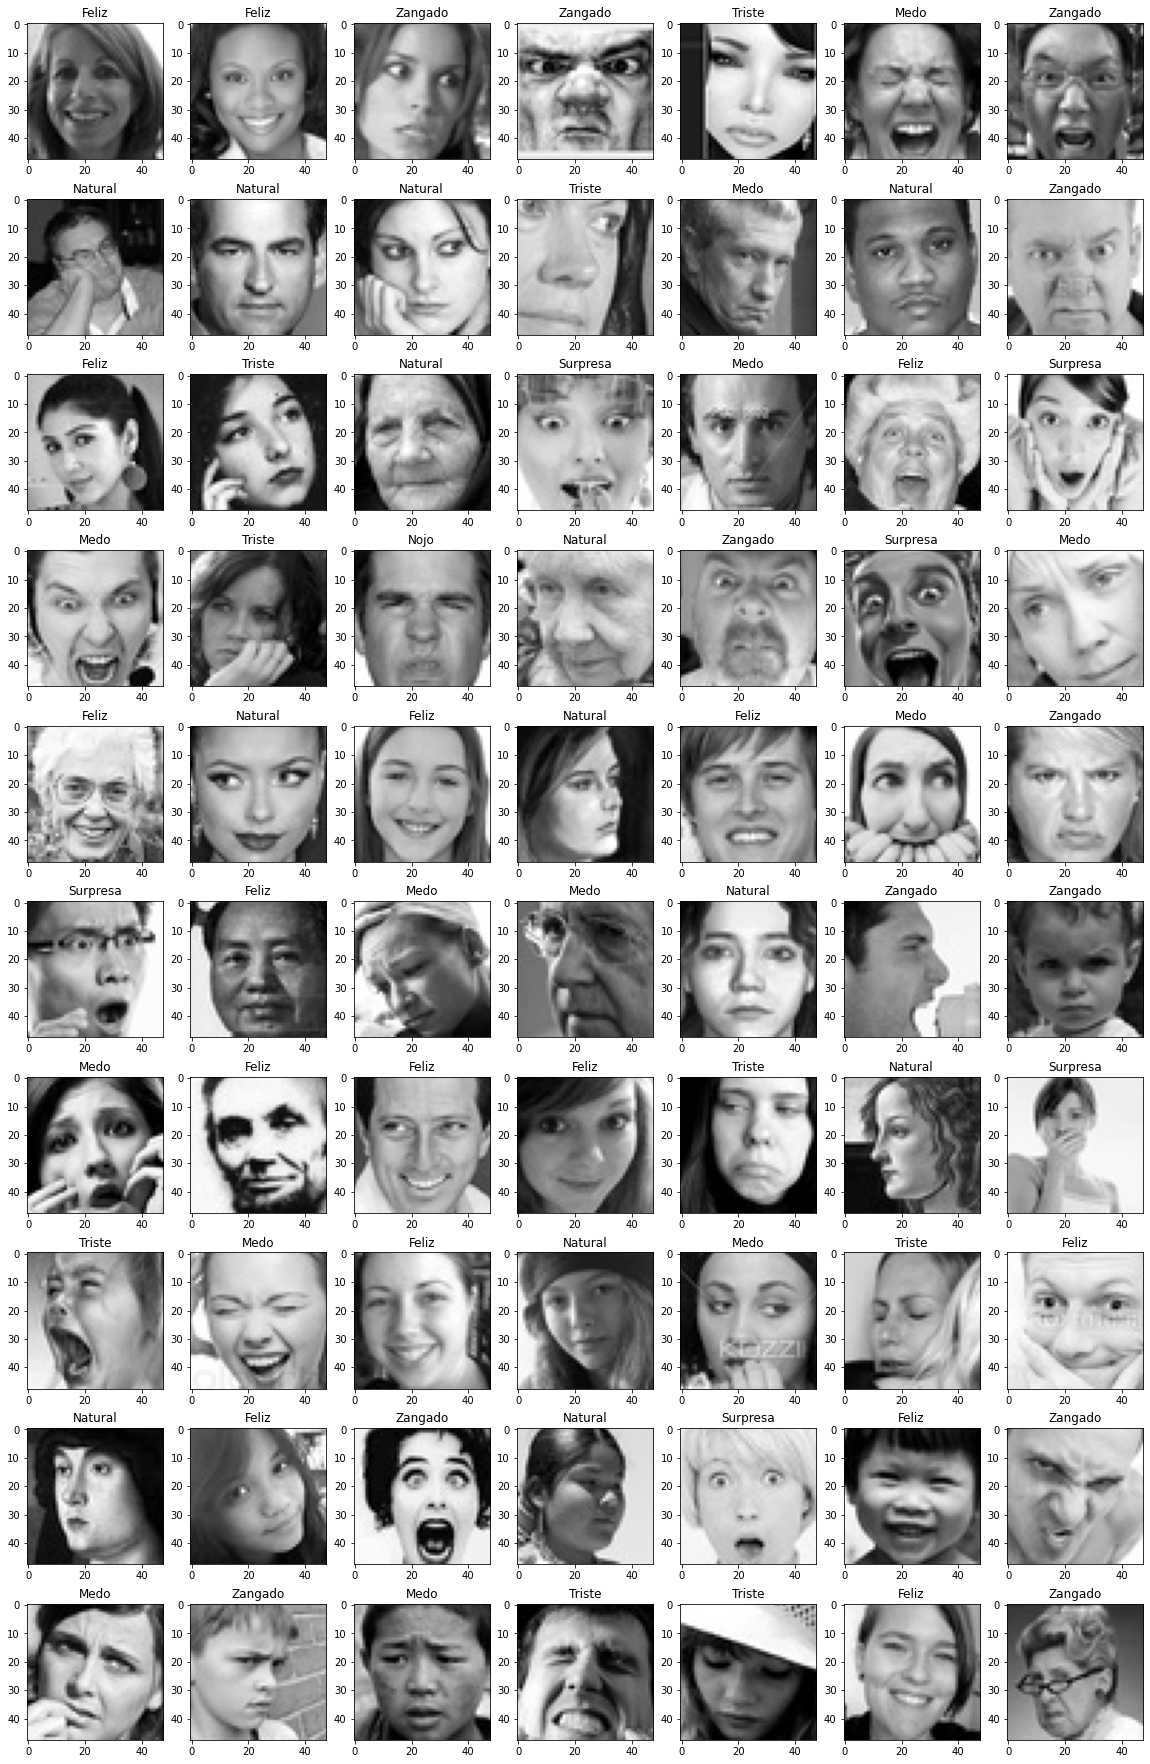

In [17]:
emocoes.plotar_batch(100)

In [18]:
emocoes.criar_csv_e_dataframe_pandas('emocoes')

Arquivo emocoes.csv criado, utilize os atributos .df_final e .df_contagem para acessar os datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria


In [19]:
emocoes.df_final.head()

,pixels,categoria
0,"[[[162.0], [197.0], [191.0], [206.0], [179.0],...",Medo
1,"[[[35.0], [35.0], [37.0], [46.0], [43.0], [54....",Feliz
2,"[[[42.0], [61.0], [83.0], [90.0], [103.0], [10...",Triste
3,"[[[30.0], [29.0], [11.0], [24.0], [27.0], [25....",Feliz
4,"[[[83.0], [112.0], [91.0], [108.0], [106.0], [...",Feliz


In [20]:
emocoes.df_contagem

,Categorias,Quantidade
0,Feliz,7207
1,Natural,4950
2,Triste,4818
3,Medo,4090
4,Zangado,3984
5,Surpresa,3163
6,Nojo,436


Pronto, agora com a classe criada, podemos usa-la sempre que precisarmos trabalhar com imagens que estão salvas em pastas separadas por categorias, o que pode facilitar muito nosso trabalho, essa classe vai ser acrescentada na pasta no arquivo bliblioteca1.py